In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PowerTransformer

### Ali Shiraee - 400422112

In [2]:
# os.chdir('drive/MyDrive/Datasets/DM-A02')

## Loading the data

In [3]:
train = pd.read_csv('mobile/train.csv')
test = pd.read_csv('mobile/test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [5]:
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [6]:
test.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


In [7]:
test.drop(columns='id', inplace=True)

Let's check null values for two dataframes:

In [8]:
print(f'There are {train.isna().sum().sum()} null values in train set.')
print(f'There are {test.isna().sum().sum()} null values in test set.')

There are 0 null values in train set.
There are 0 null values in test set.


In [9]:
train['price_range'].value_counts()

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64

In [10]:
def wrapper(clf, X, y, cv=5, scoring='accuracy', scaler=True):
    if scaler:
        clf = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
    return scores.mean()

## Part 1: Forward Selection

In [11]:
def fit_calculate(features, target, test_split):
  X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_split, random_state=42)
  model = LogisticRegression(max_iter=2000)

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  model.fit(X_train, y_train)
  y_pred = model.predict_proba(X_test)[:, 1]
  return roc_auc_score(y_test, y_pred)

In [12]:
def forward_selection(data, test_split):
    data = data.copy()
    best_auc = 0
    best_cols = []
    target = data.pop('price_range')
    cols = list(data.columns)
    for i in tqdm(range(len(cols))):
        mi_auc = 0
        mi_best_col = ''
        for j in cols:
            auc_ = fit_calculate(data[best_cols + [j]], target, test_split)
            if auc_ > mi_auc:
                mi_auc = auc_
                mi_best_col = j
        if mi_auc > best_auc:
            best_auc = mi_auc
            cols.remove(mi_best_col)
            best_cols.append(mi_best_col)

    print(f'Best columns: {best_cols}, Best AUC: {best_auc}')
    return best_cols

In [13]:
new_train = shuffle(train)
new_train['price_range'] = train['price_range'].map({0:0, 1:0, 2:1, 3:1})

In [14]:
best_cols = forward_selection(new_train, test_split=0.1)

100%|██████████| 20/20 [00:03<00:00,  6.47it/s]

Best columns: ['ram', 'battery_power', 'px_height', 'fc', 'four_g'], Best AUC: 0.9995980303487086


## Part 2: Logisitic Regression

In [15]:
X_best = new_train[best_cols]
y_best = new_train['price_range']
X_train, X_test, y_train, y_test = train_test_split(X_best, y_best, test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9907    0.9725    0.9815       109
           1     0.9677    0.9890    0.9783        91

    accuracy                         0.9800       200
   macro avg     0.9792    0.9807    0.9799       200
weighted avg     0.9802    0.9800    0.9800       200



## Part 3: PCA

In [16]:
X = new_train.drop('price_range', axis=1)
y = new_train['price_range']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=len(best_cols))
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [17]:
pd.DataFrame(X_train_pca)

,0,1,2,3,4
0,1.736574,1.568787,-2.165436,0.311695,-0.333480
1,-0.243828,2.148172,2.218541,0.027243,0.045252
2,0.861178,2.015818,0.528037,0.426953,-0.101953
3,2.076701,-1.463867,2.466416,0.419870,-0.299189
4,2.003800,-1.782657,0.422702,0.075806,1.426965
...,...,...,...,...,...
1795,-0.403540,0.920518,1.008308,-0.131663,0.678649
1796,0.270281,-0.533947,0.417910,-1.485517,0.892475
1797,-0.172662,-1.667158,1.216843,-1.694926,-0.875094
1798,-0.057301,2.609681,0.701766,1.121024,0.282172


## Part 4: LogisticRegression on PCA data

In [18]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_pca, y_train)
y_pred_pca = lr.predict(X_test_pca)

print(classification_report(y_test, y_pred_pca, digits=4))

              precision    recall  f1-score   support

           0     0.5701    0.6354    0.6010        96
           1     0.6237    0.5577    0.5888       104

    accuracy                         0.5950       200
   macro avg     0.5969    0.5966    0.5949       200
weighted avg     0.5979    0.5950    0.5947       200



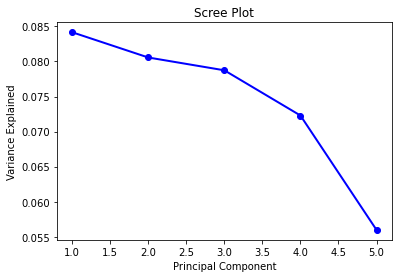

In [19]:
plt.plot(np.arange(pca.n_components_) + 1, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## Part 6,7,8: SVM, Kernels and Margins

In [20]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9694    0.9896    0.9794        96
           1     0.9902    0.9712    0.9806       104

    accuracy                         0.9800       200
   macro avg     0.9798    0.9804    0.9800       200
weighted avg     0.9802    0.9800    0.9800       200



In [21]:
def evaluate_svm_setting(X, y, kernel, degree, C=1):
    if kernel == 'poly':
        svm = SVC(kernel=kernel, degree=degree, C=C)
    else:
        svm = SVC(kernel=kernel, C=C)

    scores = wrapper(svm, X, y, cv=5, scoring='accuracy')
    if kernel == 'poly':
        print(f'kernel:{kernel}, degree:{degree}, C:{C}, ACC: {scores.mean()*100:.2f}%')
    else:
        print(f'kernel:{kernel}, C:{C}, ACC: {scores.mean()*100:.2f}%')
    print(30*'-')

In [22]:
evaluate_svm_setting(X, y, kernel='linear', degree=2)
evaluate_svm_setting(X, y, kernel='poly', degree=2)
evaluate_svm_setting(X, y, kernel='poly', degree=3)
evaluate_svm_setting(X, y, kernel='poly', degree=5)
evaluate_svm_setting(X, y, kernel='rbf', degree=None)
evaluate_svm_setting(X, y, kernel='sigmoid', degree=None)

kernel:linear, C:1, ACC: 98.40%
------------------------------
kernel:poly, degree:2, C:1, ACC: 52.80%
------------------------------
kernel:poly, degree:3, C:1, ACC: 93.00%
------------------------------
kernel:poly, degree:5, C:1, ACC: 92.25%
------------------------------
kernel:rbf, C:1, ACC: 95.55%
------------------------------
kernel:sigmoid, C:1, ACC: 97.25%
------------------------------


In [23]:
evaluate_svm_setting(X_best, y_best, kernel='linear', degree=None)
evaluate_svm_setting(X_best, y_best, kernel='poly', degree=2)
evaluate_svm_setting(X_best, y_best, kernel='poly', degree=3)
evaluate_svm_setting(X_best, y_best, kernel='poly', degree=5)
evaluate_svm_setting(X_best, y_best, kernel='rbf', degree=None)
evaluate_svm_setting(X_best, y_best, kernel='sigmoid', degree=None)

kernel:linear, C:1, ACC: 96.90%
------------------------------
kernel:poly, degree:2, C:1, ACC: 54.90%
------------------------------
kernel:poly, degree:3, C:1, ACC: 96.65%
------------------------------
kernel:poly, degree:5, C:1, ACC: 96.25%
------------------------------
kernel:rbf, C:1, ACC: 96.40%
------------------------------
kernel:sigmoid, C:1, ACC: 92.70%
------------------------------


In [24]:
evaluate_svm_setting(X, y, kernel='linear', degree=None, C=0.0001)
evaluate_svm_setting(X, y, kernel='linear', degree=None, C=1)
evaluate_svm_setting(X, y, kernel='linear', degree=None, C=10)
evaluate_svm_setting(X, y, kernel='linear', degree=None, C=100)
evaluate_svm_setting(X, y, kernel='linear', degree=None, C=1000)

kernel:linear, C:0.0001, ACC: 95.10%
------------------------------
kernel:linear, C:1, ACC: 98.40%
------------------------------
kernel:linear, C:10, ACC: 98.65%
------------------------------
kernel:linear, C:100, ACC: 98.85%
------------------------------
kernel:linear, C:1000, ACC: 98.95%
------------------------------


In [25]:
param_grid = {
              'C': [0.0001, 1, 100, 1000],
              'degree': [2, 3, 5, 7],
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
            }

grid = GridSearchCV(SVC(), param_grid, scoring='accuracy', refit=True, verbose=1, n_jobs=-1)
grid.fit(StandardScaler().fit_transform(X), y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 1, 100, 1000], 'degree': [2, 3, 5, 7],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring='accuracy', verbose=1)

In [26]:
print(grid.best_estimator_)

SVC(C=1000, degree=2, kernel='linear')


## Part 9,10 : Feature Engineering

In [27]:
def svm_train(X, y):
    svm = SVC(kernel='linear', C=1000)
    scores = wrapper(svm, X, y, cv=5, scoring='accuracy')
    print(f'Accuracy: {scores.mean()*100:.2f}%')
    print(30*'-')

In [28]:
svm_train(X, y)

Accuracy: 98.85%
------------------------------


In [29]:
X_bin = X.copy()
X_bin['battery_power_3'] = pd.cut(X['battery_power'], 3, labels=range(1,4))
X_bin['battery_power_5'] = pd.cut(X['battery_power'], 5, labels=range(1,6))
X_bin['battery_power_10'] = pd.cut(X['battery_power'], 10, labels=range(1,11))
X_bin['battery_power_neq5'] = pd.qcut(X['battery_power'], q=[0, 0.1, 0.3, 0.7, 0.9, 1], labels=range(1,6))

In [30]:
print(f'results for battery_power_3')
svm_train(X_bin.drop(columns=['battery_power_10', 'battery_power_5', 'battery_power', 'battery_power_neq5']), y)
print(f'results for battery_power_5')
svm_train(X_bin.drop(columns=['battery_power_3', 'battery_power_10', 'battery_power', 'battery_power_neq5']), y)
print(f'results for battery_power_10')
svm_train(X_bin.drop(columns=['battery_power_3', 'battery_power_5', 'battery_power', 'battery_power_neq5']), y)
print(f'results for battery_power_neq5')
svm_train(X_bin.drop(columns=['battery_power_3', 'battery_power_5', 'battery_power_10', 'battery_power']), y)

results for battery_power_3
Accuracy: 97.45%
------------------------------
results for battery_power_5
Accuracy: 98.30%
------------------------------
results for battery_power_10
Accuracy: 98.55%
------------------------------
results for battery_power_neq5
Accuracy: 97.70%
------------------------------


In [31]:
X_log = X.copy()
cols = ['battery_power', 'ram', 'px_height', 'px_width', 'mobile_wt']
for col in cols:
    X_log[col] = X_log[col].apply(lambda x: 1 if x <= 0 else x)
    X_log[col+'_log'] = np.log(X_log[col])

X_log.drop(columns=cols, inplace=True)
svm_train(X_log, y)

Accuracy: 96.75%
------------------------------


In [32]:
X_boxcox = X.copy()
scaler = PowerTransformer(method = 'box-cox')

for col in cols:
    X_boxcox[col] = X_boxcox[col].apply(lambda x: 1 if x <= 0 else x)
    X_boxcox[col+'_boxcox'] = scaler.fit_transform(X_boxcox[col].values.reshape(-1, 1))
X_boxcox.drop(columns=cols, inplace=True)
svm_train(X_boxcox, y)

Accuracy: 98.30%
------------------------------


In [33]:
X_area_vol = X.copy()
X_area_vol['area'] = X['px_height'] * X['px_width']
X_area_vol['vol'] = X['sc_h'] * X['sc_w'] * X['m_dep']

In [34]:
print(f'Results after adding area')
svm_train(X_area_vol.drop(columns=['vol', 'px_width', 'px_height']), y)
print(f'Results after adding vol')
svm_train(X_area_vol.drop(columns=['area', 'sc_h', 'sc_w', 'm_dep']), y)
print(f'Results after adding area and vol')
svm_train(X_area_vol.drop(columns=['px_width', 'px_height', 'sc_h', 'sc_w', 'm_dep']), y)

Results after adding area
Accuracy: 97.50%
------------------------------
Results after adding vol
Accuracy: 98.70%
------------------------------
Results after adding area and vol
Accuracy: 97.35%
------------------------------


In [35]:
X_last = X.copy()
X_last['vol'] = X_last['sc_h'] * X_last['sc_w'] * X_last['m_dep']
for col in cols:
    X_last[col] = X_last[col].apply(lambda x: 1 if x <= 0 else x)
    X_last[col+'_boxcox'] = scaler.fit_transform(X_last[col].values.reshape(-1, 1))
X_last['battery_power_10'] = pd.cut(X['battery_power'], 10, labels=range(1,11))
X_last.drop(columns=[*cols, 'sc_h', 'sc_w', 'm_dep', 'battery_power'], inplace=True)
svm_train(X_last, y)

Accuracy: 98.40%
------------------------------


## Part 11,12: Decision Trees

Let's Train a Vanilla Decision Tree Classifier on the data.

In [36]:
print(f'Decision Tree Vanilla: {wrapper(DecisionTreeClassifier(), X, y, scaler=False)*100:.2f}%')
print(f'Decision Tree with depth 3: {wrapper(DecisionTreeClassifier(max_depth=3), X, y, scaler=False)*100:.2f}%')
print(f'Decision Tree with depth 5: {wrapper(DecisionTreeClassifier(max_depth=5), X, y, scaler=False)*100:.2f}%')
print(f'Decision Tree with depth 10: {wrapper(DecisionTreeClassifier(max_depth=10), X, y, scaler=False)*100:.2f}%')
print(f'Decision Tree with depth 50: {wrapper(DecisionTreeClassifier(max_depth=50), X, y, scaler=False)*100:.2f}%')
print(f'Decision Tree with depth 200: {wrapper(DecisionTreeClassifier(max_depth=500), X, y, scaler=False)*100:.2f}%')

Decision Tree Vanilla: 95.00%
Decision Tree with depth 3: 92.10%
Decision Tree with depth 5: 94.80%
Decision Tree with depth 10: 95.15%
Decision Tree with depth 50: 94.20%
Decision Tree with depth 200: 94.80%


In [37]:
print(f'Decision Tree, min_samples_leaf 1: {wrapper(DecisionTreeClassifier(min_samples_leaf=1), X, y, scaler=False)*100:.2f}%')
print(f'Decision Tree, min_samples_leaf 2: {wrapper(DecisionTreeClassifier(min_samples_leaf=2), X, y, scaler=False)*100:.2f}%')
print(f'Decision Tree, min_samples_leaf 4: {wrapper(DecisionTreeClassifier(min_samples_leaf=4), X, y, scaler=False)*100:.2f}%')
print(f'Decision Tree, min_samples_leaf 8: {wrapper(DecisionTreeClassifier(min_samples_leaf=8), X, y, scaler=False)*100:.2f}%')
print(f'Decision Tree, min_samples_leaf 10: {wrapper(DecisionTreeClassifier(min_samples_leaf=10), X, y, scaler=False)*100:.2f}%')

Decision Tree, min_samples_leaf 1: 94.85%
Decision Tree, min_samples_leaf 2: 94.75%
Decision Tree, min_samples_leaf 4: 95.10%
Decision Tree, min_samples_leaf 8: 94.80%
Decision Tree, min_samples_leaf 10: 94.30%


In [38]:
param_grid = {
              'clf__criterion': ['gini', 'entropy'],
              'clf__max_depth': [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, None],
              'clf__min_samples_leaf': range(2, 20)
            }
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', DecisionTreeClassifier())
])
grid = GridSearchCV(pipe, param_grid, scoring='accuracy', refit=True, verbose=1, n_jobs=-1)
grid.fit(X, y)

Fitting 5 folds for each of 396 candidates, totalling 1980 fits


GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [1, 2, 5, 10, 20, 30, 40, 50, 100,
                                            200, None],
                         'clf__min_samples_leaf': range(2, 20)},
             scoring='accuracy', verbose=1)

In [39]:
print(grid.best_estimator_)
print(f'Best DecisionTree Accuracy: {grid.best_score_*100:.2f}%')

Pipeline(steps=[('scale', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(max_depth=50, min_samples_leaf=4))])
Best DecisionTree Accuracy: 95.55%
